In [1]:
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
from torchvision.models import resnet50
import pytorch_lightning as pl

In [2]:
torch.__version__

'2.0.1+cpu'

In [3]:
torch.cuda.is_available()

False

In [4]:
test_image_labels = pd.read_csv('./datasets/test_image_labels.csv')
test_image_labels.head(10)

,id,label
0,00a25e8f04848fe149f609fc10b891fdf67080d7,0
1,00a49d1618311c9f55fe31106b252e675b6aac5c,1
2,00b2b01146d6a6fac654ab0aee515d1262275351,1
3,01af69084811cf378874c27b47d2b432115ec2f2,0
4,01ca4aacd7904afeba78403d162b3c0fef535944,1
5,01cbdd3dda2203917bbccf700f322ce3b2868200,0
6,02ab763986c81dfb6bcff0ad4b38b3ec588e766e,1
7,02bce23515b3500551671db7911bb2777a16ca04,0
8,02bdf64ab53dbc16347f8f6ae91b11aa76bb7f85,0
9,02caa7f6d891618586f075fc0696170df340669d,1


In [6]:
test_image_labels.shape

(300, 2)

# Loading trained model

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_loaded = models.resnet50(weights='IMAGENET1K_V1').to(device)
model_loaded.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model_loaded.load_state_dict(torch.load('models/pytorch/weights.h5', map_location=torch.device('cpu')))

cpu


<All keys matched successfully>

# Make prediction

In [10]:
validation_img_paths = ["./datasets/cancer_test_dataset/00a25e8f04848fe149f609fc10b891fdf67080d7.tif",
                        "./datasets/cancer_test_dataset/00a49d1618311c9f55fe31106b252e675b6aac5c.tif",
                        "./datasets/cancer_test_dataset/00b2b01146d6a6fac654ab0aee515d1262275351.tif"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [12]:
data_T_test = T.Compose([T.Resize(224), T.ToTensor()])
validation_batch = torch.stack([data_T_test(img).to(device)
                                for img in img_list])

In [13]:
pred_logits_tensor = model_loaded(validation_batch)
pred_logits_tensor

tensor([[ 2.4713, -1.3689],
        [ 1.0237, -0.2225],
        [ 0.8304,  0.1387]], grad_fn=<AddmmBackward0>)

In [14]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.97896314, 0.02103681],
       [0.77664226, 0.22335769],
       [0.66634524, 0.33365476]], dtype=float32)

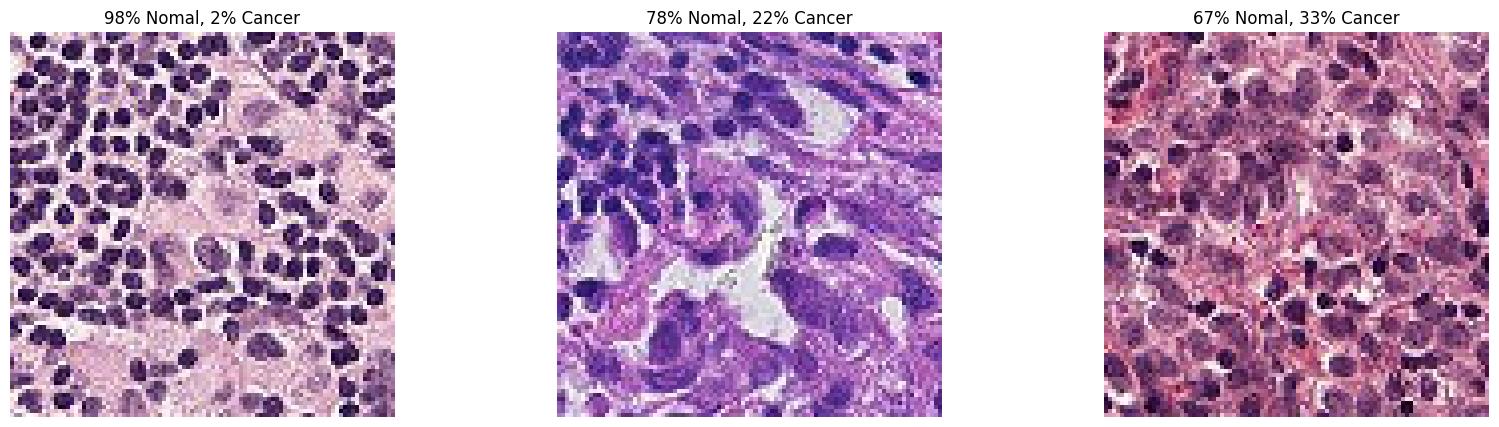

In [15]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Nomal, {:.0f}% Cancer".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

In [18]:
fig.savefig('./output/prediction.png')